# Importance sampling: toy example with parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch'''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(32768, 3, 1, 1), ratio=0.5):
    '''Makes a random image batch of size (batch_size, height, width, channels) 
    with black to white ratio of value ratio
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])]
    image_batch = torch.zeros(size) + 0.2 # to make light gray
    image_batch[idx] = 1 - 0.2 # to make light gray 
    return image_batch

The dataset class

In [4]:
class BlackWhiteDataset(Dataset):
    '''The dataloader for the black and white images'''
    def __init__(self, weight_network):
        self.dataset = random_image_data()
        
        self.weight_network = weight_network

    def __len__(self):
        return len(self.dataset)
    
    def accept_sample(self, weight_network, img):
        # Returns True if the image is accepted, False if rejected
        weight = weight_network(img)
        return bool(list(torch.utils.data.sampler.WeightedRandomSampler([1-weight, weight], 1))[0])
    
    def __getitem__(self, idx):
        # Random permutation on the dataset order (is this equivalent to uniform sampling?)
        all_idx = torch.randperm(len(dataset))
        
        # Loop through the samples and return once accepted
        for i in all_idx:
            accept = self.accept_sample(self.weight_network, self.dataset[i])
            if accept:
                return self.dataset[i]

The weight network with parameters

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        
        self.fc1.weight.data.fill_(0.5) # This as initialization because when the weights are too small
        self.fc2.weight.data.fill_(0.5) # no images are sampled

    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

weight_network = Net()

In [6]:
dataset = BlackWhiteDataset(weight_network)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [7]:
example_img = torch.cat((torch.Tensor([0.2, 0.2, 0.2]), torch.Tensor([0.8, 0.8, 0.8])))
w = weight_network(example_img)
print(w)

tensor([[0.5478],
        [0.5723]], grad_fn=<SigmoidBackward>)


Training loop with MSE

In [8]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(weight_network.parameters(), lr=0.01)

In [9]:
# for i, data in enumerate(dataloader):
#     labels = data.mean(1).view(-1, 1)
    
#     optimizer.zero_grad()

#     # forward + backward + optimize
#     outputs = weight_network(data)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

#     # print statistics
#     if i % 50 == 0:
#         print('step', i, 'loss: ', loss.item())
# #         print('outputs:', outputs[0].item(), 'labels:', labels[0].item())
# #         print()

With Helge's objective function

In [10]:
weight_network = Net()
optimizer = optim.SGD(weight_network.parameters(), lr=0.01)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
for i, data in enumerate(dataloader):
#     labels = data.mean(1).view(-1, 1)

    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = weight_network(data)
    
    # Ground truth:
    ground_truth = data.mean(1).view(-1, 1) 
    
#     loss = (data.mean(1).view(-1, 1)-0.5) * (outputs/outputs.detach()).view(-1, 1)).sum()
    loss = outputs/outputs.detach()
    
    loss.backward()
    optimizer.step()

    # print statistics
    if i % 50 == 0:
        
        w = weight_network(example_img)
        print('step', i, 'loss: ', loss.item())
        print('outputs:', w[0].item(), w[1].item(), 'ground_truth', example_img[0].item(), example_img[3].item())
        print()

step 0 loss:  1.0
outputs: 0.5991660356521606 0.6218259334564209 ground_truth 0.20000000298023224 0.800000011920929

step 50 loss:  1.0
outputs: 0.5258018970489502 0.5425145030021667 ground_truth 0.20000000298023224 0.800000011920929

step 100 loss:  1.0
outputs: 0.43836143612861633 0.4471900761127472 ground_truth 0.20000000298023224 0.800000011920929

step 150 loss:  1.0
outputs: 0.33809298276901245 0.3371690511703491 ground_truth 0.20000000298023224 0.800000011920929

step 200 loss:  1.0
outputs: 0.2370474934577942 0.22805234789848328 ground_truth 0.20000000298023224 0.800000011920929

step 250 loss:  1.0
outputs: 0.15022806823253632 0.1376960724592209 ground_truth 0.20000000298023224 0.800000011920929

step 300 loss:  1.0
outputs: 0.0856408104300499 0.07386159151792526 ground_truth 0.20000000298023224 0.800000011920929

step 350 loss:  1.0
outputs: 0.044076886028051376 0.03535878658294678 ground_truth 0.20000000298023224 0.800000011920929

step 400 loss:  1.0
outputs: 0.020839100703

step 3400 loss:  1.0
outputs: 2.791305157403836e-28 2.5124107606746342e-28 ground_truth 0.20000000298023224 0.800000011920929

step 3450 loss:  1.0
outputs: 1.0265152436804281e-28 9.249909299976487e-29 ground_truth 0.20000000298023224 0.800000011920929

step 3500 loss:  1.0
outputs: 3.775416720016204e-29 3.405344466377336e-29 ground_truth 0.20000000298023224 0.800000011920929

step 3550 loss:  1.0
outputs: 1.3878177452248738e-29 1.253865405547542e-29 ground_truth 0.20000000298023224 0.800000011920929

step 3600 loss:  1.0
outputs: 5.1004741259580204e-30 4.6169731750015275e-30 ground_truth 0.20000000298023224 0.800000011920929

step 3650 loss:  1.0
outputs: 1.8758585870196097e-30 1.6997469637748952e-30 ground_truth 0.20000000298023224 0.800000011920929

step 3700 loss:  1.0
outputs: 6.897740195116681e-31 6.257696686630674e-31 ground_truth 0.20000000298023224 0.800000011920929

step 3750 loss:  1.0
outputs: 2.5357561950910045e-31 2.303852553670952e-31 ground_truth 0.20000000298023224 0.8

step 7500 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7550 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7600 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7650 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7700 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7750 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7800 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7850 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7900 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 7950 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 8000 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 8050 

step 12200 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12250 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12300 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12350 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12400 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12450 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12500 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12550 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12600 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12650 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 12700 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929


step 16800 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 16850 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 16900 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 16950 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17000 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17050 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17100 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17150 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17200 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17250 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 17300 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929


step 21350 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21400 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21450 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21500 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21550 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21600 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21650 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21700 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21750 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21800 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 21850 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929


step 25900 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 25950 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26000 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26050 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26100 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26150 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26200 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26250 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26300 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26350 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 26400 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929


step 30600 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30650 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30700 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30750 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30800 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30850 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30900 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 30950 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 31000 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 31050 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929

step 31100 loss:  nan
outputs: nan nan ground_truth 0.20000000298023224 0.800000011920929


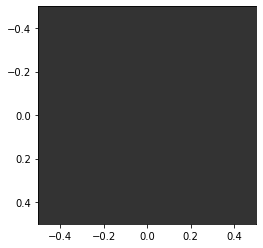

light grey = 0.2, dark grey = 0.8


In [11]:
visualize_img_batch(data)
print('light grey = 0.2, dark grey = 0.8')